In [295]:
using DrWatson
@quickactivate "Qwind"
using Qwind
using HDF5, Glob, PyPlot, YAML, PyCall, ColorSchemes, Printf

# Plotting options
LogNorm = matplotlib.colors.LogNorm
plt.style.use("science")
rcParams = PyDict(matplotlib["rcParams"])
rcParams["figure.dpi"] = 200
cmap = colorschemes[:matter]
cmap_pl_density = ColorMap("cmap", cmap.colors)
mnras_width = 252/72.27
log_ticker = pyimport("matplotlib.ticker").LogLocator

Figure(PyObject <Figure size 700x525 with 2 Axes>)

PyObject <class 'matplotlib.ticker.LogLocator'>

In [ ]:
log_ticker.

In [75]:
runs = sort(glob("model*", "/cosma5/data/durham/covid19/arnau/qwind/Qwind.jl/runs/rin_scan_reduced_save"));
rins_range = []
for run in runs
    push!(rins_range, YAML.load_file(run * "/config.yaml")["initial_conditions"]["r_in"])
end
h5_files = [run * "/results.hdf5" for run in runs];

In [36]:
bh = BlackHole(1e8 * M_SUN, 0.5, 0.0)
Rg = bh.Rg;

In [33]:
run = runs[1]
h5_file = run * "/results.hdf5"
last_it = nothing
h5open(h5_file, "r") do file
    iterations = keys(file)
    global last_it
    last_it = sort(iterations)[end]
end
density_grid_h5 = h5read(h5_file, last_it * "/density_grid")
density_grid = DensityGrid(density_grid_h5["r"], density_grid_h5["z"], density_grid_h5["grid"])
velocity_grid_h5 = h5read(h5_file, last_it * "/velocity_grid")
velocity_grid = VelocityGrid(velocity_grid_h5["r"], velocity_grid_h5["z"], velocity_grid_h5["vr_grid"], velocity_grid_h5["vz_grid"]);

VelocityGrid{Float64}([6.1, 6.1369338, 6.1892803, 6.2153992, 6.234544, 6.2500455, 6.263235, 6.2748038, 6.2851629, 6.2945791  …  8955.8217265, 9055.8217265, 9155.8217265, 9255.8217265, 9355.8217265, 9455.8217265, 9555.8217265, 9655.8217265, 9755.8217265, 9855.8217265], [0.0, 1.0e-6, 1.0e-6, 1.1e-6, 1.1e-6, 1.2e-6, 1.3e-6, 1.3e-6, 1.4e-6, 1.4e-6  …  6528.1742863, 6836.9576419, 7160.3464839, 7499.0316534, 7853.7366683, 8225.2192692, 8614.2730376, 9021.7290916, 9448.4578614, 9895.3709486], [0.0 0.0 … 0.0 0.0; 1.1832664452932734e-17 1.1832664452932734e-17 … 0.0 0.0; … ; 0.0 0.0 … 0.07026623829466314 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 8.455365583766994e-5 8.455365583766994e-5 … 0.0 0.0; … ; 0.0 0.0 … 0.06764363813719154 0.0; 0.0 0.0 … 0.0 0.0], 751, 500, GridIterator{Float64}([6.1, 6.136934, 6.18928, 6.215399, 6.234544, 6.250046, 6.263235, 6.274804, 6.285163, 6.294579  …  8955.821726, 9055.821726, 9155.821726, 9255.821726, 9355.821726, 9455.821726, 9555.821726, 9655.821726, 9755.82

In [315]:
function compute_momentum(r, z, vr, vz, n, Rg)
    θ = π / 2 - atan(z / r)
    sinθ = sin(θ)
    d = sqrt(r^2 + z^2)
    vt = sqrt(vr^2 + vz^2)
    #momentum = n * vt * C * M_P
    momentum = vt^2.0 * n * 2 * π * d^2 * sinθ * Rg^2 * C^2 * M_P
    return momentum
end
    
function compute_momentum_per_angle(density_grid, velocity_grid, ntheta=50, d = 5000)
    # theta here is measured from the z axis
    theta_range = collect(range(0, π / 2, length=ntheta))
    r_range = d .* sin.(theta_range)
    z_range = d .* cos.(theta_range)
    v_range = interpolate_velocity.(Ref(velocity_grid), r_range, z_range)
    vr_range = [v[1] for v in v_range]
    vz_range = [v[2] for v in v_range]
    n_range = interpolate_density.(Ref(density_grid), r_range, z_range)
    momentum_range = compute_momentum.(r_range, z_range, vr_range, vz_range, n_range, Rg)
    return theta_range, momentum_range
end

function compute_momentum_per_angle(h5_file::String; ntheta=50, d=5000)
    last_it = nothing
    h5open(h5_file, "r") do file
        iterations = keys(file)
        last_it = sort(iterations)[end]
    end
    density_grid_h5 = h5read(h5_file, last_it * "/density_grid")
    density_grid = DensityGrid(density_grid_h5["r"], density_grid_h5["z"], density_grid_h5["grid"])
    velocity_grid_h5 = h5read(h5_file, last_it * "/velocity_grid")
    velocity_grid = VelocityGrid(velocity_grid_h5["r"], velocity_grid_h5["z"], velocity_grid_h5["vr_grid"], velocity_grid_h5["vz_grid"])
    return compute_momentum_per_angle(density_grid, velocity_grid, ntheta, d)
end

function get_density_grid(h5_file::String, r_range, z_range)
    last_it = nothing
    h5open(h5_file, "r") do file
        iterations = keys(file)
        last_it = sort(iterations)[end]
    end
    density_grid_h5 = h5read(h5_file, last_it * "/density_grid")
    density_grid = DensityGrid(density_grid_h5["r"], density_grid_h5["z"], density_grid_h5["grid"])
    den_grid = 1e2 .* ones(length(r_range), length(z_range))
    for (i, r) in enumerate(r_range)
        for (j, z) in enumerate(z_range)
            den_grid[i, j] = interpolate_density(density_grid, r, z)
        end
    end
    return den_grid
end

function get_velocity_grid(h5_file::String, r_range, z_range)
    last_it = nothing
    h5open(h5_file, "r") do file
        iterations = keys(file)
        last_it = sort(iterations)[end]
    end
    velocity_grid_h5 = h5read(h5_file, last_it * "/velocity_grid")
    velocity_grid = VelocityGrid(velocity_grid_h5["r"], velocity_grid_h5["z"], velocity_grid_h5["vr_grid"], velocity_grid_h5["vz_grid"])
    vel_grid_r = zeros((length(r_range), length(z_range)))
    vel_grid_z = zeros((length(r_range), length(z_range)))
    for (i, r) in enumerate(r_range)
        for (j, z) in enumerate(z_range)
            v = interpolate_velocity(velocity_grid, r, z)
            vel_grid_r[i, j] = v[1]
            vel_grid_z[i, j] = v[2]
        end
    end
    return vel_grid_r, vel_grid_z
end

function plot_den_vel_grids(h5_file::String; rmin=0, rmax=5000, zmin=0, zmax=5000, n_density=250, n_velocity=50, vmin=1e2, vmax=1e6, cmap=nothing, ax=nothing, cbar=true)
    r_range_density = range(rmin, rmax, length=n_density)
    z_range_density = range(zmin, zmax, length=n_density)
    density_grid = get_density_grid(h5_file, r_range_density, z_range_density)
    density_grid .-= 2e2
    r_range_vel = range(rmin, rmax, length=n_velocity)
    z_range_vel = range(zmin, zmax, length=n_velocity)
    vel_grid_r, vel_grid_z = get_velocity_grid(h5_file, r_range_vel, z_range_vel)
    if ax === nothing
        fig, ax = plt.subplots()
    end
    cm = ax.pcolormesh(r_range_density, z_range_density, density_grid', norm=LogNorm(vmin=vmin, vmax=vmax), shading="auto", cmap=cmap)
    if cbar
        cbar = plt.colorbar(cm, ax=ax)
        cbar.set_label(L"Density [ cm$^{-3}$ ]", rotation=-90, labelpad=15)
    end
    ax.quiver(r_range_vel, z_range_vel, vel_grid_r', vel_grid_z', color="black", minlength=0)
    return ax, cm
end

Figure(PyObject <Figure size 700x525 with 2 Axes>)

plot_den_vel_grids (generic function with 2 methods)

In [ ]:
fig, ax = plt.subplots(1, 3, sharex=true, sharey=true, figsize=(2*mnras_width, 0.6mnras_width))
nums = [7, 17, 22]
cm = nothing
for i in 1:3
    ax[i], cm = plot_den_vel_grids(h5_files[nums[i]], vmin=1e4, vmax=1e7, cmap=cmap_pl_density, n_velocity=20, ax=ax[i], cbar=false)
    rin = rins_range[nums[i]]
    ax[i].set_title(L"$R_\mathrm{in}$ $=$" * @sprintf " %d" rin)
    ax[i].set_xlabel(L"$R$ [ $R_g$ ]")
end
plt.subplots_adjust(wspace=0.05)
ax[1].set_ylabel(L"$z$ [ $R_g$ ]")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.015, 0.75])
cbar = fig.colorbar(cm, cax=cbar_ax, ticks=[1e4, 1e5, 1e6, 1e7])
cbar.set_label(L"Density [ cm$^{-3}$]", rotation=-90, labelpad=15)

fig.savefig("plots/rin_grid.pdf", bbox_inches="tight")
    

In [109]:
ntheta = 250
d = 5000
n_rins = length(rins_range)
momentum_grid = zeros((n_rins, ntheta))
theta_range = nothing
for (i, model_file) in enumerate(h5_files)
    theta_range, momentum_range = compute_momentum_per_angle(model_file, ntheta=ntheta, d=d)
    momentum_grid[i,:] = momentum_range
end

Figure(PyObject <Figure size 700x525 with 2 Axes>)

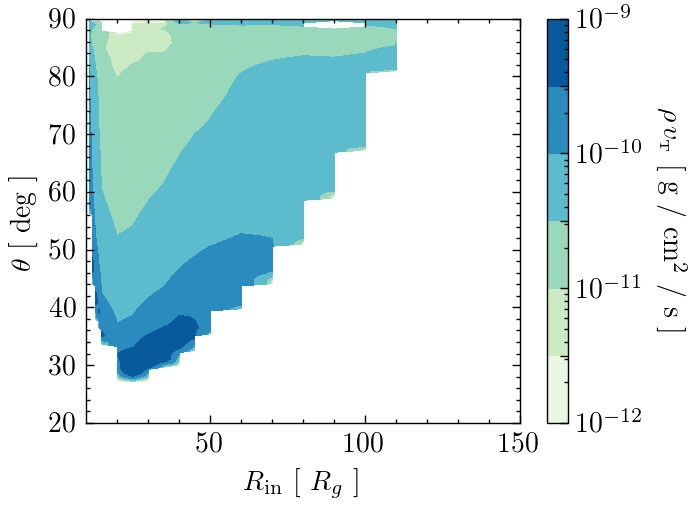

In [172]:
cmap = colorschemes[:GnBu_9]
cmap_pl = ColorMap("cmap", cmap.colors)
fig, ax = plt.subplots()
#cm = ax.pcolormesh(rins_range, theta_range .* 180 / π, momentum_grid', norm=LogNorm(vmin=1e-12, vmax=1e-9), cmap = cmap_pl, shading="auto")
cm = ax.contourf(rins_range, theta_range .* 180 / π, momentum_grid', norm=LogNorm(), levels= 10 .^ range(-12, -9, length=7), cmap = cmap_pl)
cbar = plt.colorbar(cm, ax=ax)
cbar.set_label(L"$\rho \, v_\mathrm{\scriptscriptstyle T}$  [ g / cm$^2$ / s ]", rotation = -90, labelpad=15)
ax.set_xlabel(L"$R_\mathrm{in}$ [ $R_g$ ]")
ax.set_ylabel(L"$\theta$ [ deg ]")
ax.set_xlim(10, 150)
ax.set_ylim(20, 90)
fig.savefig("plots/momentum_grid.pdf", bbox_inches="tight")

In [178]:
using CSV, DataFrames

Figure(PyObject <Figure size 700x525 with 2 Axes>)

In [179]:
df = CSV.read("/cosma5/data/durham/covid19/arnau/qwind/Qwind.jl/runs/rin_scan_reduced_save/model_011/iteration_075/streamlines.csv", DataFrame)

Figure(PyObject <Figure size 700x525 with 2 Axes>)

,line_id,tauuv,n,xi,taux,z,taueff,r
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,1.08932e13,992.346,0.0,0.0,6.84762e-17,20.0
2,1,0.0,1.07953e13,1001.35,0.0,1.55922e-7,6.88014e-17,20.0
3,1,0.0,1.06996e13,1010.3,0.0,3.13239e-7,6.91365e-17,20.0
4,1,0.0,1.05142e13,1028.11,0.0,6.31241e-7,6.98202e-17,20.0
5,1,0.0,1.01669e13,1063.24,0.0,1.28404e-6,7.10459e-17,20.0
6,1,0.0,9.55015e12,1131.9,0.0,2.65178e-6,7.33524e-17,20.0
7,1,0.0,8.55329e12,1263.82,0.0,5.63511e-6,7.7309e-17,20.0
8,1,0.0,7.14666e12,1512.57,0.0,1.25384e-5,8.3396e-17,20.0
9,1,0.0,6.19202e12,1745.77,0.0,2.06387e-5,8.79038e-17,20.0


Figure(PyObject <Figure size 700x525 with 2 Axes>)

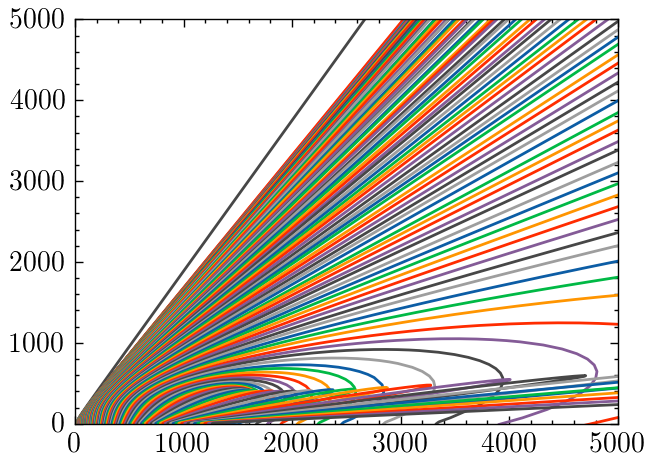

(0.0, 5000.0)

In [183]:
fig, ax = plt.subplots()
for line in unique(df.line_id)
    toplot = filter(row -> row.line_id == line, df)
    ax.plot(toplot.r, toplot.z)
end
ax.set_xlim(0,5000)
ax.set_ylim(0, 5000)